In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import splitfolders
import shutil

In [36]:
input_folder = "data"
output = "input/" #where you want the split datasets saved. one will be created if it does not exist or none is set
shutil.rmtree("input")
splitfolders.ratio(input_folder, output=output, ratio=(.8, .1, .1))

train_dir = "input/train"
validation_dir = "input/val"
test_dir = "input/test"

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 21600 files belonging to 10 classes.


In [37]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2700 files belonging to 10 classes.


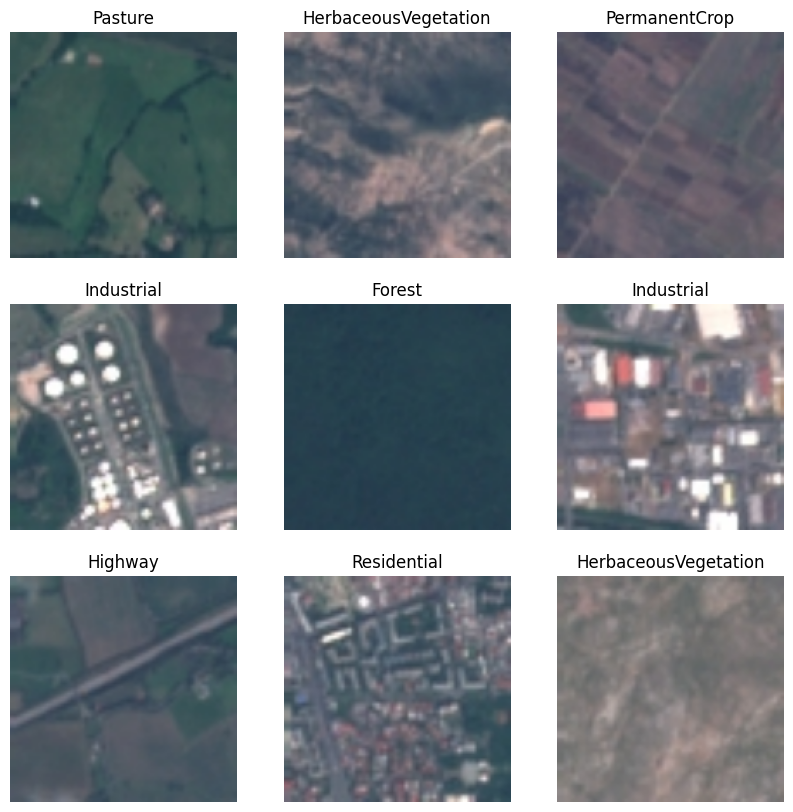

In [38]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [39]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2700 files belonging to 10 classes.


In [40]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 85
Number of test batches: 85


In [41]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [42]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

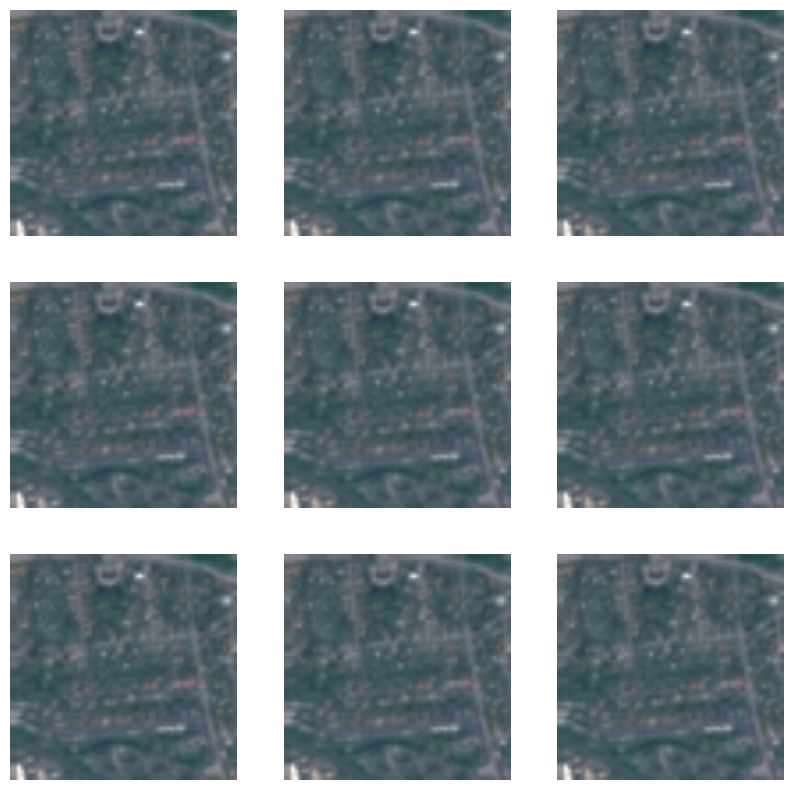

In [43]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [44]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

In [45]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.resnet_v2.ResNet101V2(input_shape=IMG_SHAPE,
                                                         include_top=False,
                                                         weights='imagenet')

In [46]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [47]:
base_model.trainable = False

In [48]:
base_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 82, 82, 64)   0           ['conv1_conv[0][0]']   

In [49]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [50]:
prediction_layer = tf.keras.layers.Dense(10, activation=tf.nn.softmax)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [51]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [52]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [53]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 resnet101v2 (Functional)    (None, 5, 5, 2048)        42626560  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

In [54]:
len(model.trainable_variables)

2

In [55]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

85/85 [==============================] - 93s 1s/step - loss: 2.7131 - accuracy: 0.1126


In [56]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.71
initial accuracy: 0.11


In [57]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
675/675 [==============================] - 907s 1s/step - loss: 1.2317 - accuracy: 0.6104 - val_loss: 0.6212 - val_accuracy: 0.8333
Epoch 2/10
675/675 [==============================] - 892s 1s/step - loss: 0.5881 - accuracy: 0.8252 - val_loss: 0.4318 - val_accuracy: 0.8733
Epoch 3/10
675/675 [==============================] - 889s 1s/step - loss: 0.4564 - accuracy: 0.8599 - val_loss: 0.3529 - val_accuracy: 0.8948
Epoch 4/10
675/675 [==============================] - 897s 1s/step - loss: 0.4014 - accuracy: 0.8745 - val_loss: 0.3161 - val_accuracy: 0.9056
Epoch 5/10
675/675 [==============================] - 901s 1s/step - loss: 0.3584 - accuracy: 0.8863 - val_loss: 0.2887 - val_accuracy: 0.9133
Epoch 6/10
675/675 [==============================] - 933s 1s/step - loss: 0.3357 - accuracy: 0.8942 - val_loss: 0.2693 - val_accuracy: 0.9170
Epoch 7/10
675/675 [==============================] - 927s 1s/step - loss: 0.3188 - accuracy: 0.9008 - val_loss: 0.2587 - val_accuracy: 0.9181

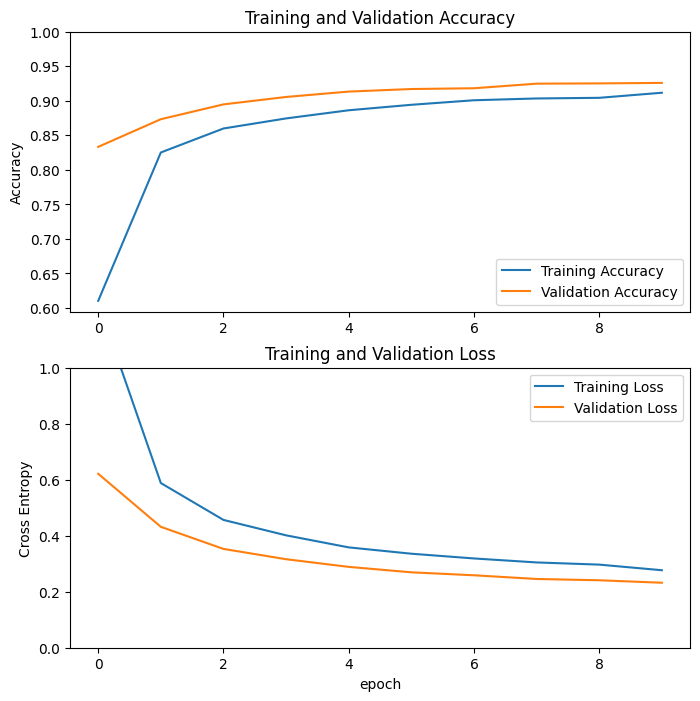

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

model.save("model/SatNet_Before_fine101.h5")

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [61]:
base_model.trainable = True

In [62]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 327

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  377


In [63]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [64]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 resnet101v2 (Functional)    (None, 5, 5, 2048)        42626560  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

In [65]:
len(model.trainable_variables)

48

In [66]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
675/675 [==============================] - 1387s 2s/step - loss: 0.2032 - accuracy: 0.9328 - val_loss: 0.1348 - val_accuracy: 0.9515
Epoch 11/20
675/675 [==============================] - 1368s 2s/step - loss: 0.1446 - accuracy: 0.9510 - val_loss: 0.1243 - val_accuracy: 0.9544
Epoch 12/20
675/675 [==============================] - 1407s 2s/step - loss: 0.1206 - accuracy: 0.9617 - val_loss: 0.1132 - val_accuracy: 0.9581
Epoch 13/20
675/675 [==============================] - 1398s 2s/step - loss: 0.1044 - accuracy: 0.9654 - val_loss: 0.1123 - val_accuracy: 0.9619
Epoch 14/20
675/675 [==============================] - 1464s 2s/step - loss: 0.0901 - accuracy: 0.9708 - val_loss: 0.1084 - val_accuracy: 0.9637
Epoch 15/20
675/675 [==============================] - 1432s 2s/step - loss: 0.0829 - accuracy: 0.9726 - val_loss: 0.1047 - val_accuracy: 0.9663
Epoch 16/20
675/675 [==============================] - 1438s 2s/step - loss: 0.0751 - accuracy: 0.9752 - val_loss: 0.1031 - val_ac

In [67]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

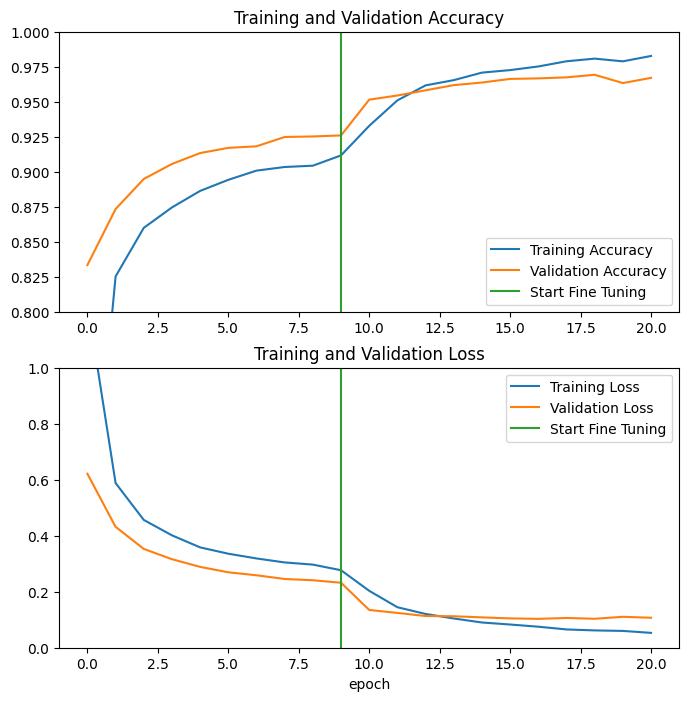

In [68]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [69]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

85/85 [==============================] - 148s 2s/step - loss: 0.0921 - accuracy: 0.9774
Test accuracy : 0.9774073958396912


In [70]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

Predictions:
 [3.66281228e-07 1.05247699e-13 9.96939421e-01 1.74481526e-10
 1.53722850e-11 2.66554660e-12 3.06026335e-03 2.30957448e-10
 2.60887313e-13 8.69139830e-12 1.14630225e-07 9.99990225e-01
 7.29941291e-07 4.44214123e-07 6.08965170e-11 8.51584991e-06
 2.78931598e-08 3.21959561e-08 3.92264248e-08 2.68117883e-09
 1.00000000e+00 3.00007387e-22 1.59627561e-17 9.67919321e-13
 5.76314822e-15 6.58789470e-17 7.11937731e-11 1.76112812e-18
 6.14438891e-17 1.01472810e-17 6.90043141e-15 1.90298566e-18
 1.63575078e-12 1.08500544e-05 9.99989152e-01 7.13869839e-16
 8.04333197e-11 2.45812100e-08 1.37373246e-09 1.72930843e-13
 2.57184135e-10 2.32832671e-14 4.07180322e-12 3.01027484e-07
 3.62888955e-11 9.99999404e-01 1.93115057e-09 1.46920479e-11
 2.18789637e-07 3.26178559e-12 4.86560348e-09 1.00000000e+00
 2.86450224e-08 2.64692690e-09 4.21279629e-13 1.46538137e-09
 2.56535282e-09 9.90236337e-09 4.26100683e-10 1.51987244e-12
 2.22415551e-07 9.72158687e-15 8.22313595e-09 1.04417801e-07
 1.3734729

In [71]:
model.save("model/SatNet101.h5")

In [73]:
model.save_weights("Weights/SatNet101_W.h5")